In [10]:
import torch
import torch.distributions as distributions
from pccg.splines import bs
from pccg.CL import contrastive_learning
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
torch.set_default_dtype(torch.double)

The Müller potential is defined as

\begin{equation*}
U(x, y; \alpha) = \alpha \cdot \sum_{i=1}^{4}{A_i \cdot \exp( \left[ a_i \cdot (x-x^0_i)^2 + b_i \cdot (x-x^0_i)(y-y^0_i) + c_i \cdot (y-y^0_i)^2 \right] )}
\end{equation*}

where $(A_1, A_2, A_3, A_4)$ = (-200, -100, -170, 15), $(a_1, a_2, a_3, a_4)$ = (-1, -1, -6.5, 0.7), $(b_1, b_2, b_3, b_4)$ = (0, 0, 11, 0.6),$(c_1, c_2, c_3, c_4)$ = (-10, -10, -6.5, 0.7), $(x^0_1, x^0_2, x^0_3, x^0_4)$ =  (1, 0, -0.5, -1), and $(y^0_1, y^0_2, y^0_3, y^0_4)$ = (0, 0.5, 1.5, 1).

$\alpha$ is a parameter that control the rugedness of the potential. In this tutorial, we will set it to 0.05.


In [2]:
def compute_Muller_potential(x, alpha):
    A = (-200., -100., -170., 15.)
    b = (0., 0., 11., 0.6)
    ac = (x.new_tensor([-1.0, -10.0]),
          x.new_tensor([-1.0, -10.0]),
          x.new_tensor([-6.5, -6.5]),
          x.new_tensor([0.7, 0.7]))

    x0 = (x.new_tensor([ 1.0, 0.0]),
          x.new_tensor([ 0.0, 0.5]),
          x.new_tensor([-0.5, 1.5]),
          x.new_tensor([-1.0, 1.0]))

    U = 0
    for i in range(4):
        diff = x - x0[i]
        U = U + A[i]*torch.exp(torch.sum(ac[i]*diff**2, -1) + b[i]*torch.prod(diff, -1))

    U = alpha * U
    return U

In [3]:
def generate_grid(x1_min, x1_max, x2_min, x2_max, size = 100):
    x1 = torch.linspace(x1_min, x1_max, size)
    x2 = torch.linspace(x2_min, x2_max, size)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing="ij")
    grid = torch.stack([grid_x1, grid_x2], dim = -1)
    x = grid.reshape((-1, 2))
    return x

In [4]:
alpha = 0.05
x1_min, x1_max = -1.5, 1.0
x2_min, x2_max = -0.5, 2.0

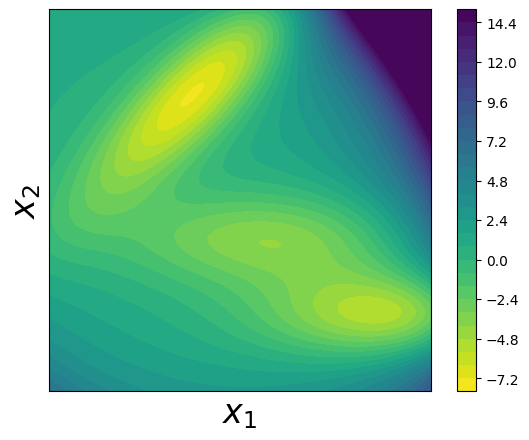

In [ ]:
x = generate_grid(x1_min, x1_max, x2_min, x2_max)
fig, axes = plt.subplots()
alpha = 0.05
U = compute_Muller_potential(x, alpha)
U = U.reshape(100, 100)
U[U>15] = 15
U = U.T
plt.contourf(U, levels = 30, extent = (x1_min, x1_max, x2_min, x2_max), cmap = cm.viridis_r)
plt.xlabel(r"$x_1$", fontsize = 24)
plt.ylabel(r"$x_2$", fontsize = 24)
plt.colorbar()
plt.tight_layout()
axes.set_aspect('equal')
plt.tick_params(which='both', bottom=False, top=False, right = False, left = False, labelbottom=False, labelleft=False)

In [6]:
num_reps = 10
alphas = torch.linspace(0.0, alpha, num_reps)

num_steps = 510000
x_record = []
accept_rate = 0
x = torch.stack((x1_min + torch.rand(num_reps)*(x1_max - x1_min),
                 x2_min + torch.rand(num_reps)*(x2_max - x2_min)),
                dim = -1)
energy = compute_Muller_potential(x, 1.0)

for k in range(num_steps):
    if (k + 1) % 100000 == 0:
        print("idx of steps: {}".format(k))

    ## sampling within each replica
    delta_x = torch.normal(0, 1, size = (num_reps, 2))*0.3
    x_p = x + delta_x
    energy_p = compute_Muller_potential(x_p, 1.0)

    ## accept based on energy
    accept_prop = torch.exp(-alphas*(energy_p - energy))
    accept_flag = torch.rand(num_reps) < accept_prop

    ## considering the bounding effects
    accept_flag = accept_flag & torch.all(x_p > x_p.new_tensor([x1_min, x2_min]), -1) \
                              & torch.all(x_p < x_p.new_tensor([x1_max, x2_max]), -1)

    x_p[~accept_flag] = x[~accept_flag]
    energy_p[~accept_flag] = energy[~accept_flag]
    x = x_p
    energy = energy_p

    ## calculate overall accept rate
    accept_rate = accept_rate + (accept_flag.float() - accept_rate)/(k+1)
    
    ## exchange
    if k % 10 == 0:
        for i in range(1, num_reps):
            accept_prop = torch.exp((alphas[i] - alphas[i-1])*(energy[i] - energy[i-1]))
            accept_flag = torch.rand(1) < accept_prop
            if accept_flag.item():
                tmp = x[i]
                x[i] = x[i-1]
                x[i-1] = tmp

                tmp = energy[i]
                energy[i] = energy[i-1]
                energy[i-1] = tmp
        if k >= 10000:
            x_record.append(x.clone().numpy())
            
x_record = np.array(x_record)

idx of steps: 99999
idx of steps: 199999
idx of steps: 299999
idx of steps: 399999
idx of steps: 499999


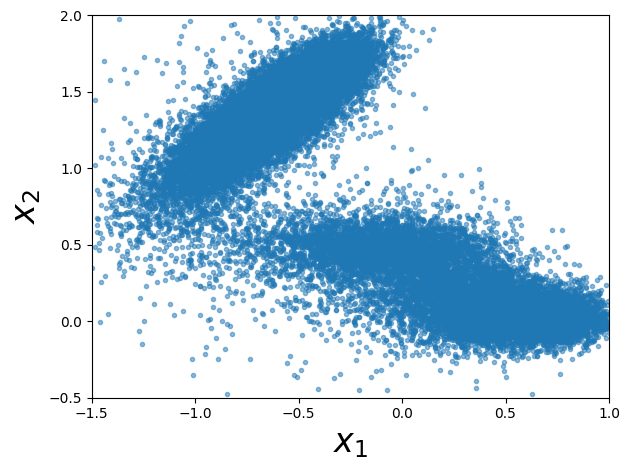

In [7]:
x_samples = x_record[:, -1, :]

#### plot samples
fig = plt.figure()
fig.clf()
plt.plot(x_samples[:, 0], x_samples[:, 1], ".", alpha=0.5)
plt.xlim((x1_min, x1_max))
plt.ylim((x2_min, x2_max))
plt.xlabel(r"$x_1$", fontsize=24)
plt.ylabel(r"$x_2$", fontsize=24)
axes.set_aspect("equal")
plt.tight_layout()
plt.show()

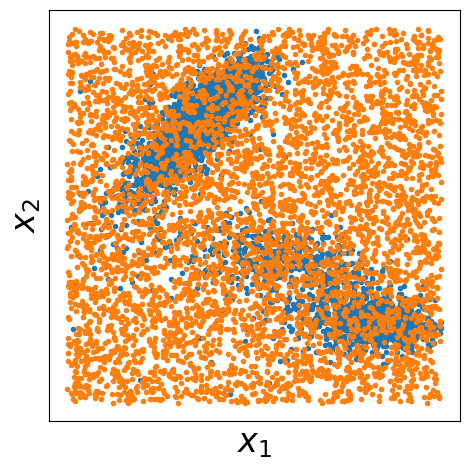

In [9]:
xp = torch.from_numpy(x_samples)
num_samples_p = xp.shape[0]

## samples from q
num_samples_q = num_samples_p

q_dist = distributions.Independent(
    distributions.Uniform(
        low=torch.tensor([x1_min, x2_min]), high=torch.tensor([x1_max, x2_max])
    ),
    1,
)
xq = q_dist.sample((num_samples_q,))

fig, axes = plt.subplots()
plt.plot(xp[::10, 0], xp[::10, 1], ".", label="data", markersize=6)
plt.plot(xq[::10, 0], xq[::10, 1], ".", label="noise", markersize=6)
plt.xlabel(r"$x_1$", fontsize=24)
plt.ylabel(r"$x_2$", fontsize=24)
plt.tick_params(
    which="both",
    bottom=False,
    top=False,
    right=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)
plt.tight_layout()
axes.set_aspect("equal")
plt.savefig("./output/data_and_noise_samples.png")

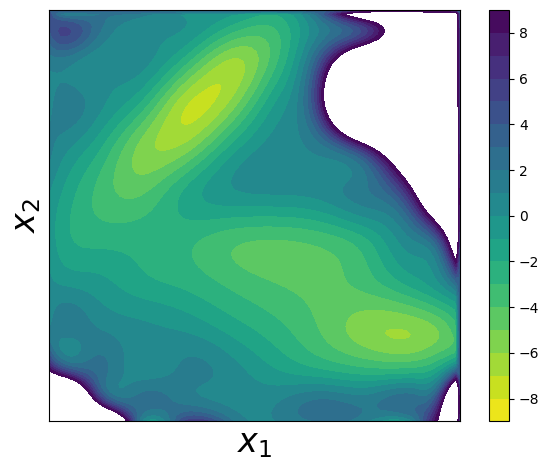

In [11]:
x1_knots = torch.linspace(x1_min, x1_max, steps=10)[1:-1]
x2_knots = torch.linspace(x2_min, x2_max, steps=10)[1:-1]

x1_boundary_knots = torch.tensor([x1_min, x1_max])
x2_boundary_knots = torch.tensor([x2_min, x2_max])


def compute_basis(x, x1_knots, x2_knots, x1_boundary_knots, x2_boundary_knots):
    x1_basis = bs(x[:, 0], x1_knots, x1_boundary_knots)
    x2_basis = bs(x[:, 1], x2_knots, x2_boundary_knots)
    x_basis = x1_basis[:, :, None] * x2_basis[:, None, :]
    x_basis = x_basis.reshape([x_basis.shape[0], -1])
    return x_basis


xp_basis = compute_basis(xp, x1_knots, x2_knots, x1_boundary_knots, x2_boundary_knots)
xq_basis = compute_basis(xq, x1_knots, x2_knots, x1_boundary_knots, x2_boundary_knots)

log_q_noise = q_dist.log_prob(xq)
log_q_data = q_dist.log_prob(xp)

theta, F = contrastive_learning(
    log_q_noise,
    log_q_data,
    xq_basis,
    xp_basis,
    options={"disp": True, "gtol": 1e-6, "ftol": 1e-12},
)

x_grid = generate_grid(x1_min, x1_max, x2_min, x2_max, size=100)
x_grid_basis = compute_basis(
    x_grid, x1_knots, x2_knots, x1_boundary_knots, x2_boundary_knots
)
up = torch.matmul(x_grid_basis, theta)
up = up.reshape(100, 100)
up = up.T.numpy()

up = up - up.min() + -7.3296
fig, axes = plt.subplots()
plt.contourf(
    up,
    levels=np.linspace(-9, 9, 19),
    extent=(x1_min, x1_max, x2_min, x2_max),
    cmap=cm.viridis_r,
)
plt.xlabel(r"$x_1$", fontsize=24)
plt.ylabel(r"$x_2$", fontsize=24)
plt.tick_params(
    which="both",
    bottom=False,
    top=False,
    right=False,
    left=False,
    labelbottom=False,
    labelleft=False,
)
plt.colorbar()
plt.tight_layout()
axes.set_aspect("equal")
plt.show()